<a href="https://colab.research.google.com/github/ilfattvru/ML-DL/blob/main/%D0%BE%D1%82%D1%82%D0%BE%D0%BA_%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D0%B5%D0%B9_Kaggle_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решение конкурса на kaggle.com
https://www.kaggle.com/c/advanced-dls-spring-2021/

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить, используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.


# Первая часть. Исследование

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Загрузка данных

Качаем данные, разбиваем на категориальные и численные признаки. Смотрим на наличие нанов.

In [ ]:
!gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K  # train.csv
!gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r  # test.csv
!gdown 199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y  # submission.csv

Downloading...
From: https://drive.google.com/uc?id=1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K
To: /content/train.csv
100% 664k/664k [00:00<00:00, 90.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r
To: /content/test.csv
100% 218k/218k [00:00<00:00, 69.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y
To: /content/submission.csv
100% 14.7k/14.7k [00:00<00:00, 34.8MB/s]


In [ ]:
data = pd.read_csv('./train.csv')

In [ ]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [ ]:

nan_per_row = data.isna().sum().reset_index()
nan_per_row.columns = ['Column', 'NaNы']


print(nan_per_row)

                      Column  NaNы
0               ClientPeriod     0
1            MonthlySpending     0
2                 TotalSpent     0
3                        Sex     0
4            IsSeniorCitizen     0
5                 HasPartner     0
6                   HasChild     0
7            HasPhoneService     0
8    HasMultiplePhoneNumbers     0
9         HasInternetService     0
10  HasOnlineSecurityService     0
11           HasOnlineBackup     0
12       HasDeviceProtection     0
13      HasTechSupportAccess     0
14               HasOnlineTV     0
15      HasMovieSubscription     0
16          HasContractPhone     0
17        IsBillingPaperless     0
18             PaymentMethod     0
19                     Churn     0


## Анализ данных

Довольно важный этап: смотрим на данные и пытаемся понять, что к чему и как будет лучше действовать в дальнейшем. В этом нам помогут графики.

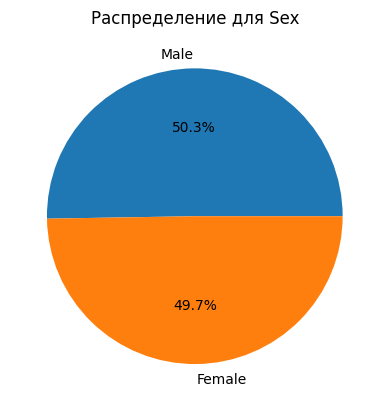

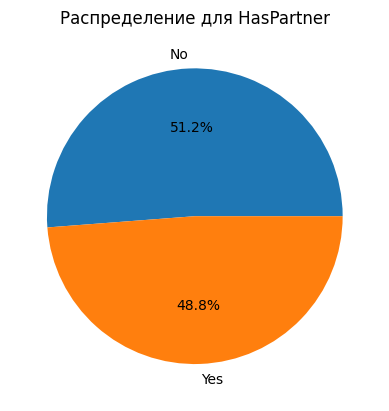

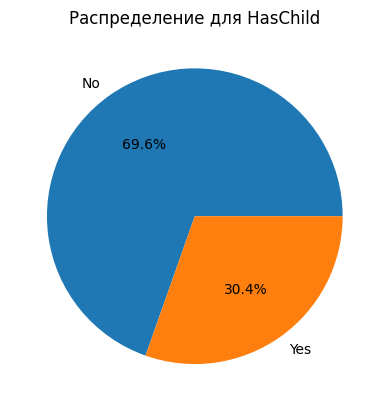

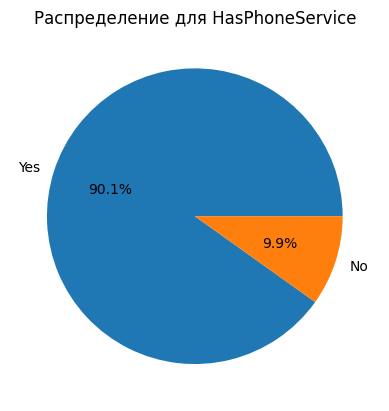

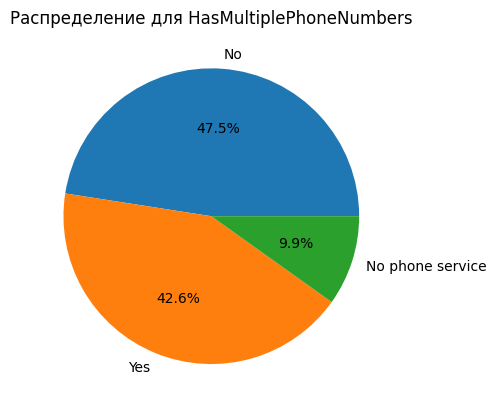

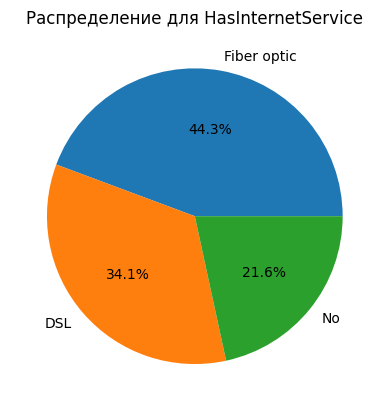

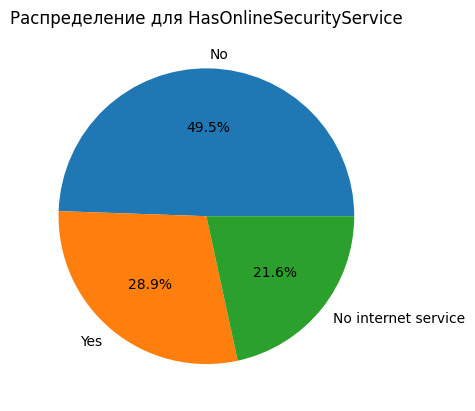

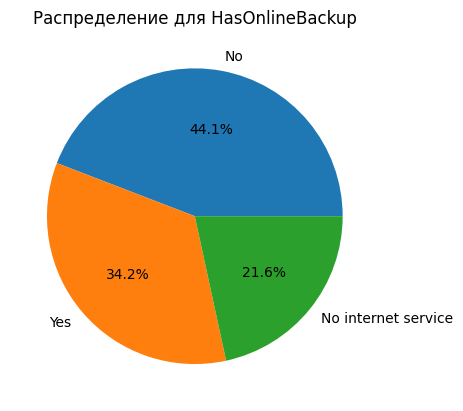

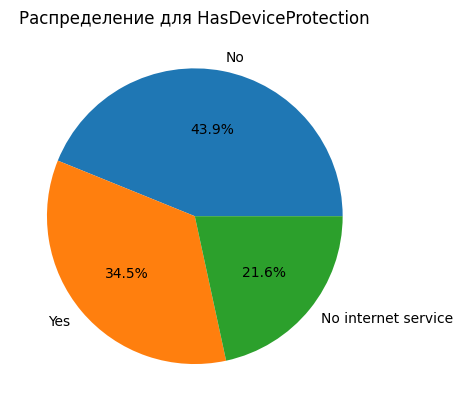

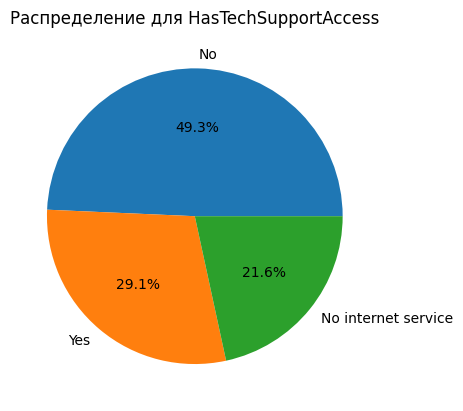

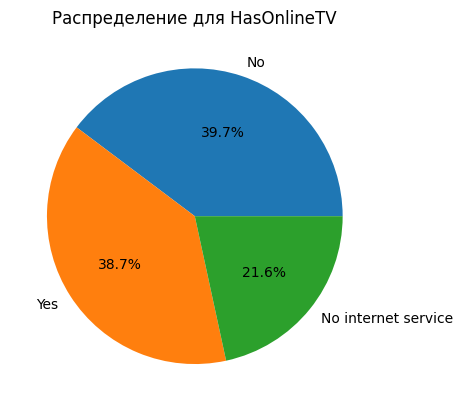

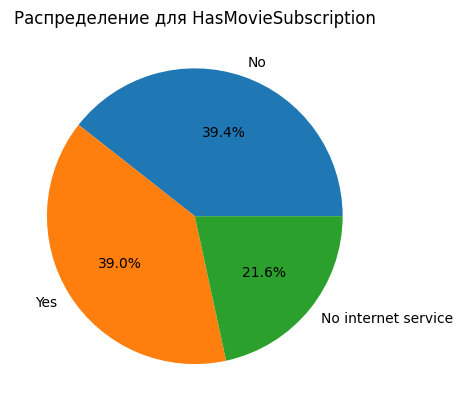

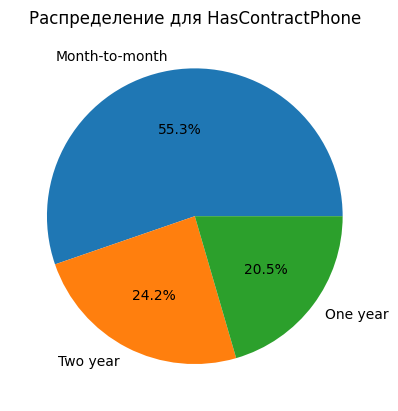

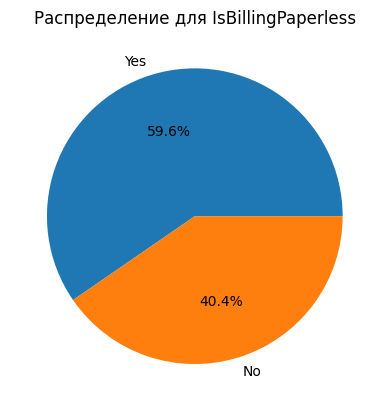

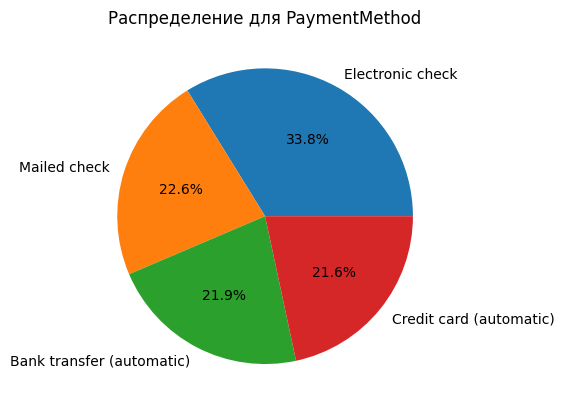

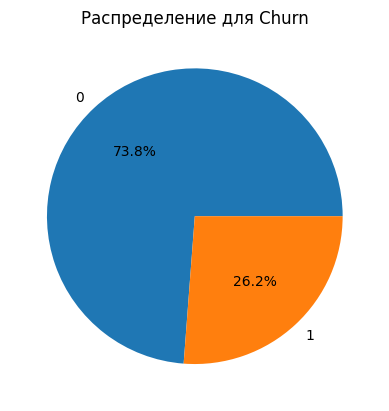

In [ ]:
for column in data[cat_cols].columns:
    if data[column].dtype == 'object':
        value_counts = data[column].value_counts()
        plt.figure()
        plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
        plt.title(f'Распределение для {column}')
        plt.show()

val = data['Churn'].value_counts()
plt.pie(val, labels=val.index, autopct='%1.1f%%')
plt.title(f'Распределение для Churn')
plt.show()

Наиболее инетересен тут последний график целевой переменной. Видим, что распределение неодинаковое, а значит банальный accuracy здесь не подойдет. Нужно применить нормализацию данных и использовать roc-auc для оценки качества моделей.

## Применение линейных моделей

Обработка данных, нормировка и one-hot-encoding. После - применение логистической регрессии.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
import pandas as pd

# Предполагается, что data, cat_cols, num_cols и target_col уже определены

cat_data = data[cat_cols]
num_data = data[num_cols]

cat_data = cat_data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

dummy_data = pd.get_dummies(cat_data)

X = pd.concat([num_data, dummy_data], axis=1)
X.replace(' ', np.nan, inplace=True)
X = X.dropna()


y = data[target_col]
y = data[target_col].loc[X.index]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)


scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_valid[num_cols] = scaler.transform(X_valid[num_cols])

Logistic_model = LogisticRegressionCV(Cs=15, cv=5,  scoring='roc_auc', random_state=42, max_iter=1000)

Logistic_model.fit(X_train, y_train)

y_pred_prob = Logistic_model.predict_proba(X_valid)[:, 1]

roc_auc = roc_auc_score(y_valid, y_pred_prob)

print(f'ROC-AUC: {roc_auc:.4f}')


ROC-AUC: 0.8443


Удалось получить довольно высокое качество ROC-AUC: 0.84

## Применение градиентного бустинга

Если мы хотим получить точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с параметрами по умолчанию дает 80% результата за 0% усилий.

Мы будем использовать catboost.

1) Разделим выборку на train/valid. Протестируем catboost cо стандартными параметрами.

2) Протестируем разные занчения параметров количества деревьев и learning_rate'а и выберем лучшую по метрике ROC-AUC комбинацию.

In [ ]:
#pip install catboost

from catboost import CatBoostClassifier

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)


model_default = CatBoostClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

roc_auc_cat_boost = roc_auc_score(y_valid, y_pred)
print(f'ROC-AUC: {roc_auc_cat_boost:.4f}')

Learning rate set to 0.019048
0:	learn: 0.6799319	total: 3.72ms	remaining: 3.72s
1:	learn: 0.6671347	total: 8.09ms	remaining: 4.04s
2:	learn: 0.6549963	total: 11.8ms	remaining: 3.92s
3:	learn: 0.6445072	total: 15.6ms	remaining: 3.89s
4:	learn: 0.6331015	total: 19.8ms	remaining: 3.94s
5:	learn: 0.6227975	total: 23.6ms	remaining: 3.91s
6:	learn: 0.6125627	total: 27.4ms	remaining: 3.89s
7:	learn: 0.6027458	total: 31.3ms	remaining: 3.89s
8:	learn: 0.5936008	total: 35.3ms	remaining: 3.88s
9:	learn: 0.5851817	total: 39.1ms	remaining: 3.87s
10:	learn: 0.5768848	total: 43.3ms	remaining: 3.89s
11:	learn: 0.5690860	total: 47.1ms	remaining: 3.88s
12:	learn: 0.5613459	total: 50.9ms	remaining: 3.87s
13:	learn: 0.5540856	total: 54.6ms	remaining: 3.85s
14:	learn: 0.5475573	total: 58.4ms	remaining: 3.84s
15:	learn: 0.5417070	total: 62.3ms	remaining: 3.83s
16:	learn: 0.5357399	total: 66.2ms	remaining: 3.83s
17:	learn: 0.5300697	total: 70ms	remaining: 3.82s
18:	learn: 0.5257030	total: 73.8ms	remaining: 

In [ ]:
model = CatBoostClassifier(iterations=5000, learning_rate=0.01, depth=5, eval_metric='AUC', verbose=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

roc_auc_cat_boost = roc_auc_score(y_valid, y_pred)
print(f'ROC-AUC: {roc_auc_cat_boost:.4f}')

0:	total: 2.67ms	remaining: 13.3s
100:	total: 261ms	remaining: 12.7s
200:	total: 536ms	remaining: 12.8s
300:	total: 793ms	remaining: 12.4s
400:	total: 1.04s	remaining: 12s
500:	total: 1.3s	remaining: 11.7s
600:	total: 1.57s	remaining: 11.5s
700:	total: 1.83s	remaining: 11.2s
800:	total: 2.07s	remaining: 10.9s
900:	total: 2.33s	remaining: 10.6s
1000:	total: 2.64s	remaining: 10.5s
1100:	total: 2.89s	remaining: 10.2s
1200:	total: 3.14s	remaining: 9.94s
1300:	total: 3.41s	remaining: 9.7s
1400:	total: 3.68s	remaining: 9.45s
1500:	total: 3.93s	remaining: 9.16s
1600:	total: 4.19s	remaining: 8.89s
1700:	total: 4.44s	remaining: 8.61s
1800:	total: 4.71s	remaining: 8.36s
1900:	total: 4.96s	remaining: 8.08s
2000:	total: 5.21s	remaining: 7.81s
2100:	total: 5.47s	remaining: 7.55s
2200:	total: 5.73s	remaining: 7.29s
2300:	total: 5.98s	remaining: 7.02s
2400:	total: 6.24s	remaining: 6.75s
2500:	total: 6.5s	remaining: 6.49s
2600:	total: 6.76s	remaining: 6.24s
2700:	total: 7.01s	remaining: 5.97s
2800:	to

В данном случае "игра с аргументами" не дала сильного улучшения модели, так что как будто значения по умолчанию довольно хороши.
Второй вывод: LogisticRegressionCV уделывает градиентный бустинг, хотя казалось бы такого быть не должно, но видим, что видим.

# Предсказания

In [ ]:
best_model = model

In [ ]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

X_test = pd.get_dummies(X_test)

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

submission['Churn'] = best_model.predict_proba(X_test)[:, 1]

submission.to_csv('./my_submission.csv', index=False)

Fun fact на платформе Kaggle с тестовыми данными, самой выгодной моделью оказался градиентный бустинг.